# Importing Libraries

In [1]:
!pip install --upgrade tensorflow_hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score , recall_score , f1_score , confusion_matrix , classification_report , accuracy_score , roc_auc_score , roc_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense , Dropout , Flatten , Conv2D , MaxPool2D , Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array

import tensorflow_hub as hub
import warnings
warnings.filterwarnings(action = "ignore")
sns.set(font_scale =2 , palette = "bright")

     |████████████████████████████████| 108 kB 29.7 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Creating path for train and test sets

In [2]:
train_path = '/work/traindata/traindata'
test_path = '/work/testdata/testdata'

# Applying Scaling

In [3]:
train_gen = ImageDataGenerator(rescale = 1./255 , horizontal_flip=True , shear_range=0.2 , zoom_range=0.2 , height_shift_range=0.2 , width_shift_range=0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

# Loading images with the help of the flow_from_directory function

In [4]:
train_set = train_gen.flow_from_directory(directory=train_path , target_size = (224,224) , class_mode = 'binary' , batch_size = 16)
test_set = test_gen.flow_from_directory(directory=test_path , target_size = (224,224) , class_mode = "binary" , batch_size = 16)

Found 2891 images belonging to 2 classes.
Found 1330 images belonging to 2 classes.


# Creating callbacks function

In [5]:
def callbacks_func(model_path , verbosity = 1, monitoring = "val_loss") : 
  early = EarlyStopping(monitor=monitoring , verbose = verbosity , patience = 5 , restore_best_weights=True)
  check = ModelCheckpoint(filepath = model_path , monitor = monitoring , verbose = verbosity , save_best_only=True)

  callbacks = [early , check]

  return callbacks

# Building model with Sequential API

In [6]:
from tensorflow.python.ops import losses
tf.random.set_seed(seed = 42)

model_cnn = Sequential(layers = [
    
  Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = "relu" ,input_shape = (224, 224,3)),
  MaxPool2D(padding = "same"),
  Conv2D(filters = 64 , kernel_size = (3,3) , padding="same" , activation = "relu"),
  MaxPool2D(padding = "same"),
  Conv2D(filters = 64 , kernel_size = (3,3,) , padding = "same" , activation = "relu"),
  MaxPool2D(padding = "same"),
  Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = "relu"),
  MaxPool2D(padding = "same"),
  Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = "relu"),
  MaxPool2D(padding = "same"),
  Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = "relu"),
  MaxPool2D(padding = "same"),
  Flatten(),
  Dense(units = 256 , activation = "relu"),
  Dense(units = 256 , activation = "relu"),
  Dense(units = 256 , activation = "relu"),
  Dense(units = 528 , activation = "relu"),
  Dropout(rate = 0.1 , seed = 42),
  Dense(units = 528 , activation = "relu"),
  Dropout(rate = 0.1 , seed = 42),
  Dense(units = 528 , activation = "relu"),
  Dropout(rate = 0.1 , seed = 42),
  Dense(units = 528 , activation = "relu"),
  Dropout(rate = 0.1 , seed = 42),
  Dense(units = 1 , activation = "sigmoid") 

] , name = "CNN")

model_cnn.compile(optimizer= Adam() , loss= BinaryCrossentropy() , metrics = ["accuracy"])

model_training = model_cnn.fit(train_set , validation_data = test_set , batch_size = 16 , callbacks = callbacks_func(model_path = f"{model_cnn.name}.h5") , verbose = 1 , epochs = 100)

2022-09-14 06:15:28.604214: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2022-09-14 06:15:28.604250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-aecf7276-0135-45de-9959-147dce059a01): /proc/driver/nvidia/version does not exist
2022-09-14 06:15:28.604539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/100
181/181 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6538
Epoch 1: val_loss improved from inf to 0.63990, saving model to CNN.h5
181/181 [==============================] - 828s 5s/step - loss: 0.6510 - accuracy: 0.6538 - val_loss: 0.6399 - val_accuracy: 0.68

# Evaluate the performance of the model

In [7]:
train_score = model_cnn.evaluate(train_set)
test_score = model_cnn.evaluate(test_set)

84/84 [==============================] - 97s 1s/step - loss: 0.6225 - accuracy: 0.6857


# Metrics for Deep Learning model

In [8]:
y_test = test_set.labels.astype(dtype = np.float32)
y_train = train_set.labels.astype(dtype = np.float32)

y_pred_test = tf.math.round(tf.squeeze(model_cnn.predict(test_set))).numpy()
y_pred_train = tf.math.round(tf.squeeze(model_cnn.predict(train_set))).numpy()

roc_train = roc_auc_score(y_train , y_pred_train)
f1_train = f1_score(y_train , y_pred_train)
prec_train = precision_score(y_train , y_pred_train)
recall_train = recall_score(y_train , y_pred_train)
accuracy_train = accuracy_score(y_train , y_pred_train)


roc_test = roc_auc_score(y_test , y_pred_test)
f1_test = f1_score(y_test , y_pred_test)
prec_test = precision_score(y_test , y_pred_test)
recall_test = recall_score(y_test , y_pred_test)
accuracy_test = accuracy_score(y_test , y_pred_test)


print("The metrics for Train Set")
print("The Roc auc score is {:.2%}".format(roc_train))
print("The F1 score is {:.2%}".format(f1_train))
print("The Precision score is {:.2%}".format(prec_train))
print("The Recall train is {:.2%}".format(recall_train))
print("The Accuracy train is {:.2%}".format(accuracy_train))
print()
print("The metrics for Test Set")
print("The Roc auc score is {:.2%}".format(roc_test))
print("The F1 score is {:.2%}".format(f1_test))
print("The Precision score is {:.2%}".format(prec_test))
print("The Recall train is {:.2%}".format(recall_test))
print("The Accuracy train is {:.2%}".format(accuracy_test))

181/181 [==============================] - 252s 1s/step
The metrics for Train Set
The Roc auc score is 50.00%
The F1 score is 79.32%
The Precision score is 65.72%
The Recall train is 100.00%
The Accuracy train is 65.72%

The metrics for Test Set
The Roc auc score is 50.00%
The F1 score is 81.36%
The Precision score is 68.57%
The Recall train is 100.00%
The Accuracy train is 68.57%


# Confusion Matrices for Deep Learning model 

Text(0.5, 128.50000000000014, 'The Predictions')

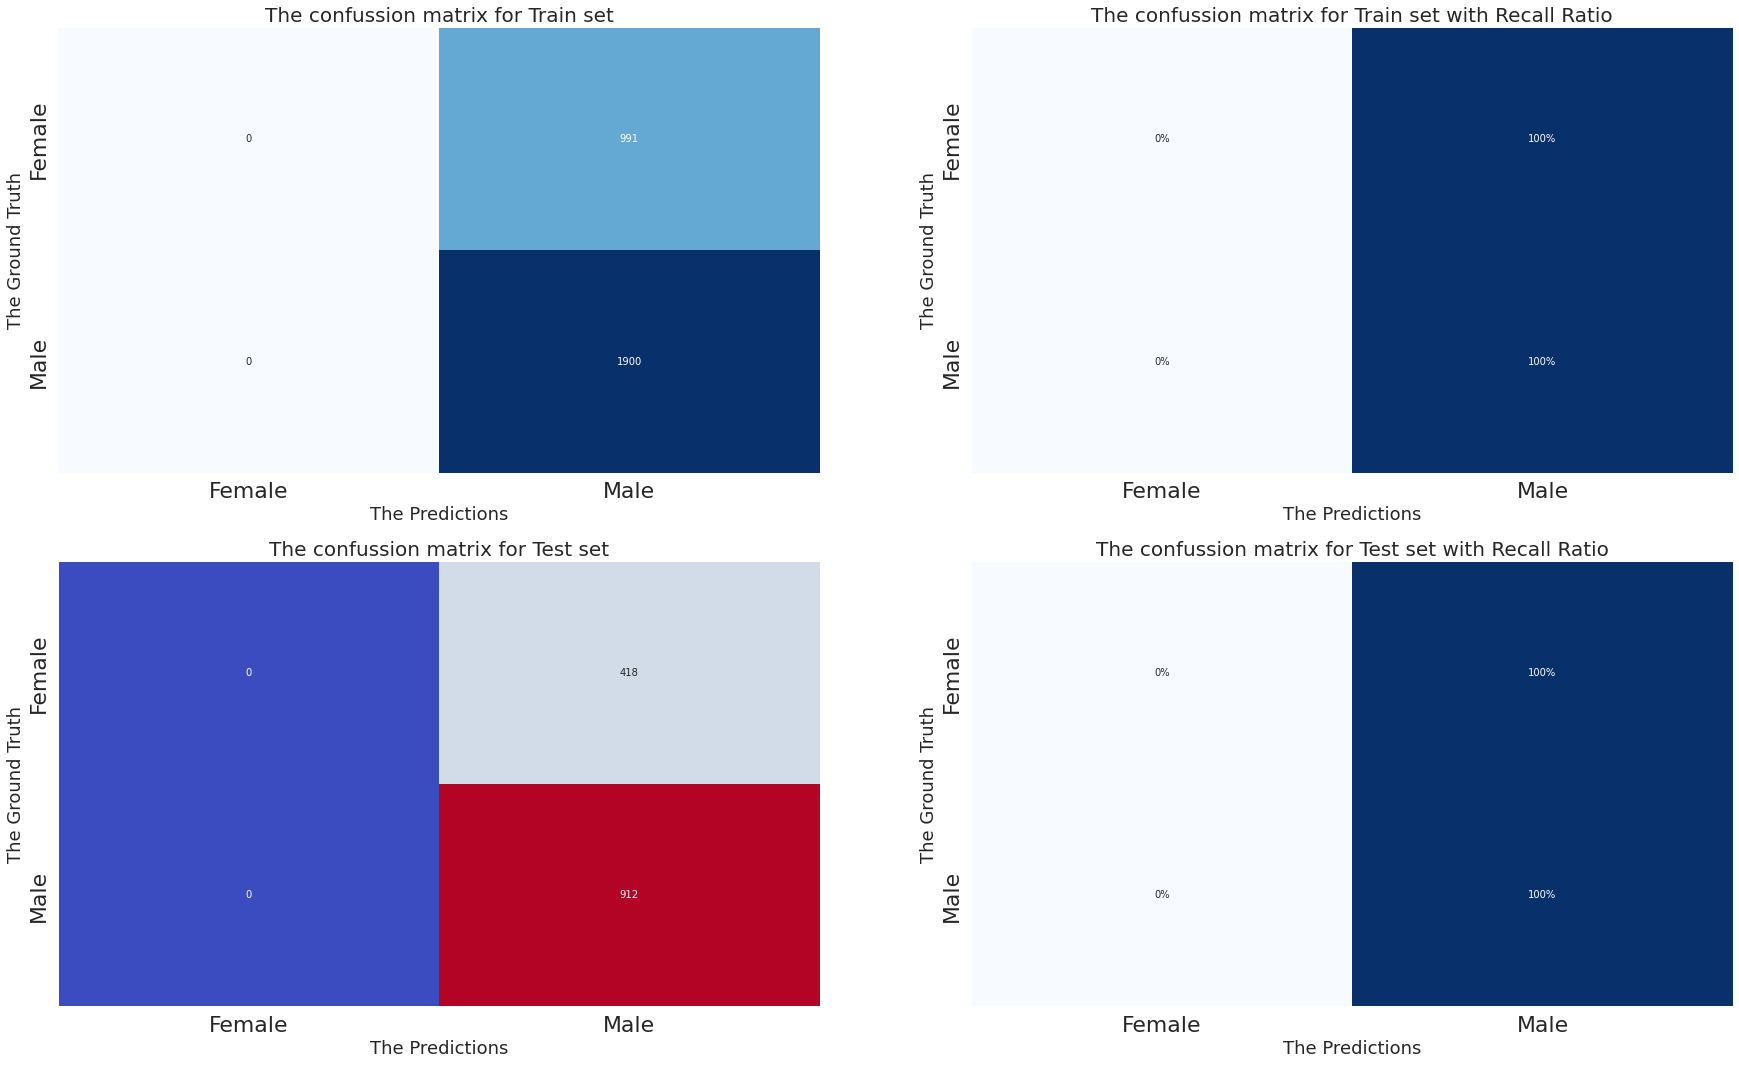

In [9]:

cm_train = confusion_matrix(y_train , y_pred_train)
cm_test = confusion_matrix(y_test , y_pred_test)


plt.figure(figsize = (30,18))
plt.subplot(2,2,1)
sns.heatmap(data = cm_train , cmap = plt.cm.Blues , cbar = False , yticklabels = ['Female' , 'Male'] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".5g")
plt.title("The confussion matrix for Train set" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)
plt.subplot(2,2,2)
upper_stack = cm_train[0]/np.sum(cm_train , axis = 1)[0]
lower_stack = cm_train[1]/np.sum(cm_train , axis  = 1)[1]
result = np.vstack([upper_stack , lower_stack])
sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , yticklabels = ["Female" , "Male"] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".0%")
plt.title("The confussion matrix for Train set with Recall Ratio" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)


plt.subplot(2,2,3)
sns.heatmap(data = cm_test , cmap = plt.cm.coolwarm , cbar = False , yticklabels = ['Female' , 'Male'] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".5g")
plt.title("The confussion matrix for Test set" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)
plt.subplot(2,2,4)
upper_stack = cm_test[0]/np.sum(cm_test , axis = 1)[0]
lower_stack = cm_test[1]/np.sum(cm_test , axis  = 1)[1]
result = np.vstack([upper_stack , lower_stack])
sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , yticklabels = ["Female" , "Male"] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".0%")
plt.title("The confussion matrix for Test set with Recall Ratio" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)


# Roc Curve for Deep Learning model

84/84 [==============================] - 94s 1s/step


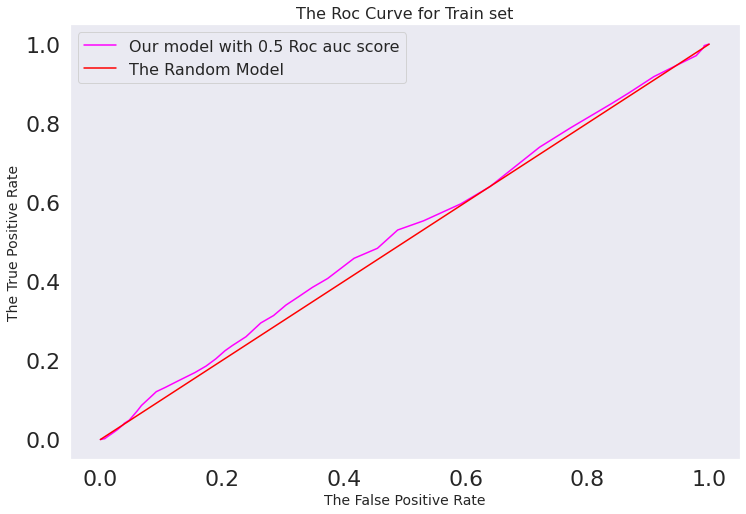

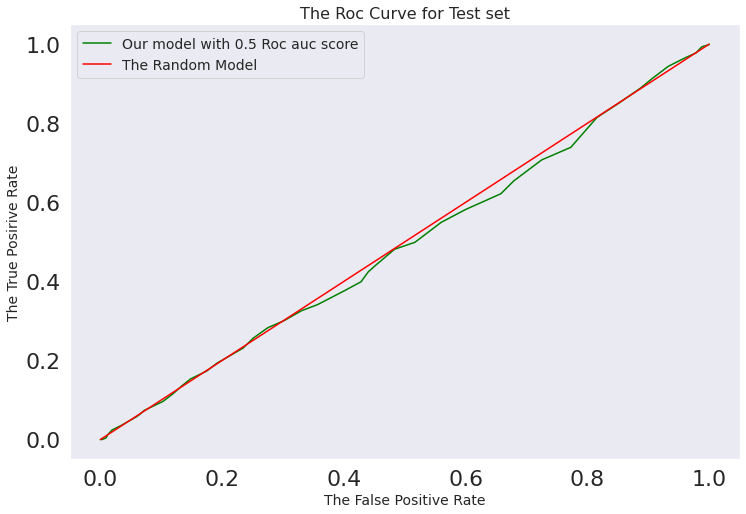

In [10]:
y_pred_proba_train = tf.squeeze(model_cnn.predict(train_set))
y_pred_proba_test = tf.squeeze(model_cnn.predict(test_set))

plt.figure(figsize = (12,8))


fpr,tpr , _ = roc_curve(y_train , y_pred_proba_train)
plt.plot(fpr, tpr , label = f"Our model with {np.round(roc_train , 2)} Roc auc score" , c = "magenta")
plt.plot([0,1] , [0,1] , label = "The Random Model" , c = "red")
plt.title("The Roc Curve for Train set" , fontsize = 16)
plt.xlabel("The False Positive Rate" , fontsize = 14)
plt.ylabel("The True Positive Rate" , fontsize = 14)
plt.grid()
plt.legend(loc = "best" , fontsize = 16)
plt.show()

print()
plt.figure(figsize = (12,8))
fpr,tpr , _ = roc_curve(y_test , y_pred_proba_test)
plt.plot(fpr, tpr, label = f"Our model with {np.round(roc_test,2)} Roc auc score" , c = "green")
plt.plot([0,1] , [0,1] , label = "The Random Model" , c = "red")
plt.title("The Roc Curve for Test set" , fontsize = 16)
plt.ylabel("The True Posirive Rate" , fontsize = 14)
plt.xlabel("The False Positive Rate" , fontsize = 14)
plt.grid()
plt.legend(loc = "best" , fontsize = 14)
plt.show()

# Creating Image Prediction function

In [11]:
import os
from tensorflow.keras.preprocessing.image import load_img
import random
LABEL_DICTIONARY = dict([(value, key) for key, value in train_set.class_indices.items()])
def make_random_predictions(class_name, custom_objects = None,
  model_path = None, vgg_model = True):
  model = load_model(filepath = model_path, custom_objects = custom_objects)
  random_images = random.choices(population = os.listdir(path = f'/work/testdata/testdata/{class_name}'), k =
  5)
  for random_image in random_images:
    filepath = f'/work/testdata/testdata/{class_name}/{random_image}'
    loading_image = load_img(path = filepath, target_size = (224, 224))
    convertin_into_array = img_to_array(img = loading_image)
    expanding_dimensions = np.expand_dims(a = convertin_into_array, axis = 0)
    if vgg_model:
      preprocessed_image = preprocess_input(x = expanding_dimensions)
    else:
      preprocessed_image = expanding_dimensions / 255.0
      actual_class = class_name.capitalize()
      predicted_label = tf.cast(x = tf.math.round(x = tf.squeeze(input = model.predict(x = preprocessed_image))), dtype = tf.int32).numpy()
      predicted_proba = tf.squeeze(input = model.predict(x = preprocessed_image)).numpy()
      predicted_class = LABEL_DICTIONARY[predicted_label].capitalize()
    if predicted_label == 1:
      if predicted_class == actual_class:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {predicted_proba:.2%}', c = 'green')
        plt.axis('off')
        plt.show()
        print()
      else:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {predicted_proba:.2%}', c = 'red')
        plt.axis('off')
        plt.show()
        print()
    else:
      if predicted_class == actual_class:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {1.0 - predicted_proba:.2%}', c = 'green')
        plt.axis('off')
        plt.show()
        print()
      else:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {1.0 - predicted_proba:.2%}', c = 'red')
        plt.axis('off')
        plt.show()
        print()

# Predictions of women

1/1 [==============================] - 0s 70ms/step


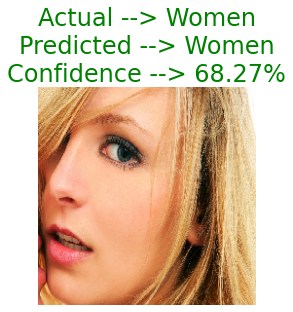


1/1 [==============================] - 0s 55ms/step


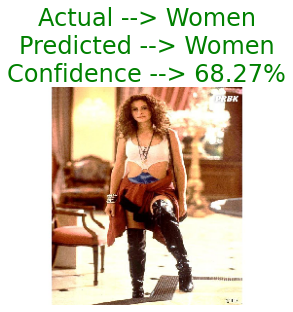


1/1 [==============================] - 0s 33ms/step


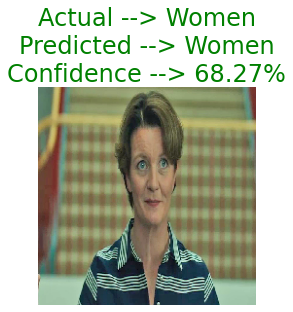


1/1 [==============================] - 0s 68ms/step


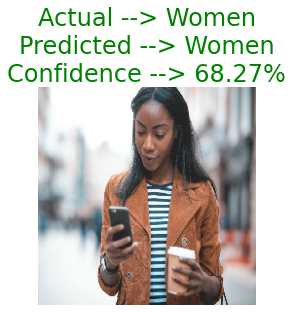


1/1 [==============================] - 0s 69ms/step


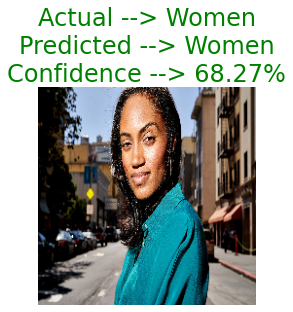

In [12]:
make_random_predictions(class_name="women" , model_path="/work/CNN.h5" , vgg_model=False)

# Predictions of Men

1/1 [==============================] - 0s 88ms/step


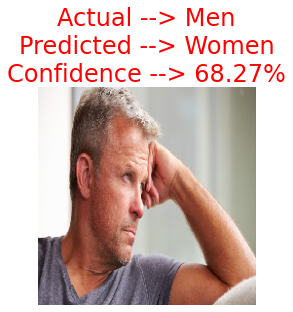


1/1 [==============================] - 0s 87ms/step


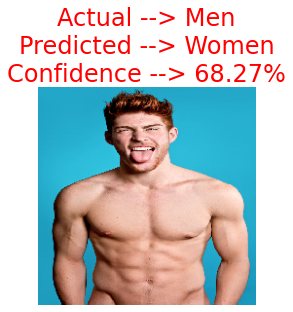


1/1 [==============================] - 0s 74ms/step


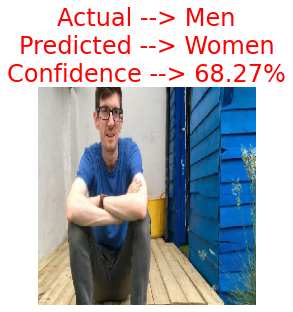


1/1 [==============================] - 0s 79ms/step


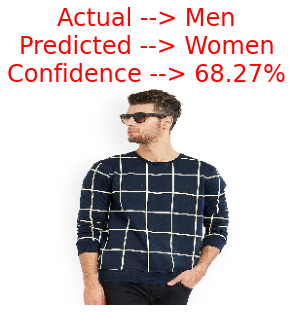


1/1 [==============================] - 0s 68ms/step


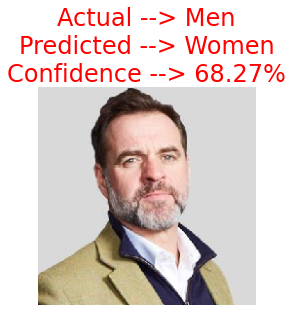

In [13]:
make_random_predictions(class_name="men" , model_path="/work/CNN.h5" , vgg_model=False)

# Let's build a Feature extraction model with Functional API.

In [14]:
resnet_50 = hub.KerasLayer(handle = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1', trainable = False)

In [15]:
from tensorflow.keras import Model

tf.random.set_seed(seed = 42)

# Creating a Resnet50 feature extraction model with Functional API
input_layer = Input(shape = (224, 224, 3), name = 'Input_Layer')
x = resnet_50(input_layer)
output_layer = Dense(units = 1, activation = 'sigmoid', name = 'Output_Layer')(x)
model_2 = Model(inputs = input_layer, outputs = output_layer, name = 'Feature_Extraction_Resnet_50')

# Compiling the model
model_2.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_2 = model_2.fit(train_set, epochs = 100, validation_data = test_set,
                               callbacks = callbacks_func(model_path = f'{model_2.name}.h5'),
                               verbose = 1)

Epoch 1/100
181/181 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8409
Epoch 1: val_loss improved from inf to 0.30439, saving model to Feature_Extraction_Resnet_50.h5
181/181 [==============================] - 938s 5s/step - loss: 0.3564 - accuracy: 0.8409 - val_loss: 0.3044 - val_accuracy: 0.8774
Epoch 2/100
181/181 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9070
Epoch 2: val_loss improved from 0.30439 to 0.22518, saving model to Feature_Extraction_Resnet_50.h5
181/181 [==============================] - 962s 5s/step - loss: 0.2269 - accuracy: 0.9070 - val_loss: 0.2252 - val_accuracy: 0.9180
Epoch 3/100
181/181 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9156
Epoch 3: val_loss improved from 0.22518 to 0.21310, saving model to Feature_Extraction_Resnet_50.h5
181/181 [==============================] - 977s 5s/step - loss: 0.2105 - accuracy: 0.9156 - val_loss: 0.2131 - val_accuracy: 0.9188
Epoch 4/100
181/1

# Evaluate the performance of the model

In [16]:
train_score = model_2.evaluate(train_set)
test_score = model_2.evaluate(test_set)

84/84 [==============================] - 290s 3s/step - loss: 0.1673 - accuracy: 0.9474


# Metrics for Functional API

In [18]:
y_test = test_set.labels.astype(dtype = np.float32)
y_train = train_set.labels.astype(dtype = np.float32)

y_pred_test = tf.math.round(tf.squeeze(model_2.predict(test_set))).numpy()
y_pred_train = tf.math.round(tf.squeeze(model_2.predict(train_set))).numpy()

roc_train = roc_auc_score(y_train , y_pred_train)
gini_train = (2*roc_train) - 1
f1_train = f1_score(y_train , y_pred_train)
prec_train = precision_score(y_train , y_pred_train)
recall_train = recall_score(y_train , y_pred_train)
accuracy_train = accuracy_score(y_train , y_pred_train)


roc_test = roc_auc_score(y_test , y_pred_test)
gini_test = (2*roc_test)-1
f1_test = f1_score(y_test , y_pred_test)
prec_test = precision_score(y_test , y_pred_test)
recall_test = recall_score(y_test , y_pred_test)
accuracy_test = accuracy_score(y_test , y_pred_test)


print("The metrics for Train Set")
print("The Roc auc score is {:.2%}".format(roc_train))
print("The Gini score is {:.2%}".format(gini_train))
print("The F1 score is {:.2%}".format(f1_train))
print("The Precision score is {:.2%}".format(prec_train))
print("The Recall train is {:.2%}".format(recall_train))
print("The Accuracy train is {:.2%}".format(accuracy_train))
print()
print("The metrics for Test Set")
print("The Roc auc score is {:.2%}".format(roc_test))
print("The Gini score is {:.2%}".format(gini_test))
print("The F1 score is {:.2%}".format(f1_test))
print("The Precision score is {:.2%}".format(prec_test))
print("The Recall train is {:.2%}".format(recall_test))
print("The Accuracy train is {:.2%}".format(accuracy_test))

181/181 [==============================] - 685s 4s/step
The metrics for Train Set
The Roc auc score is 52.05%
The Gini score is 4.10%
The F1 score is 67.30%
The Precision score is 67.12%
The Recall train is 67.47%
The Accuracy train is 56.90%

The metrics for Test Set
The Roc auc score is 52.69%
The Gini score is 5.37%
The F1 score is 70.70%
The Precision score is 70.24%
The Recall train is 71.16%
The Accuracy train is 59.55%


# Confusion Matrices for Functional API

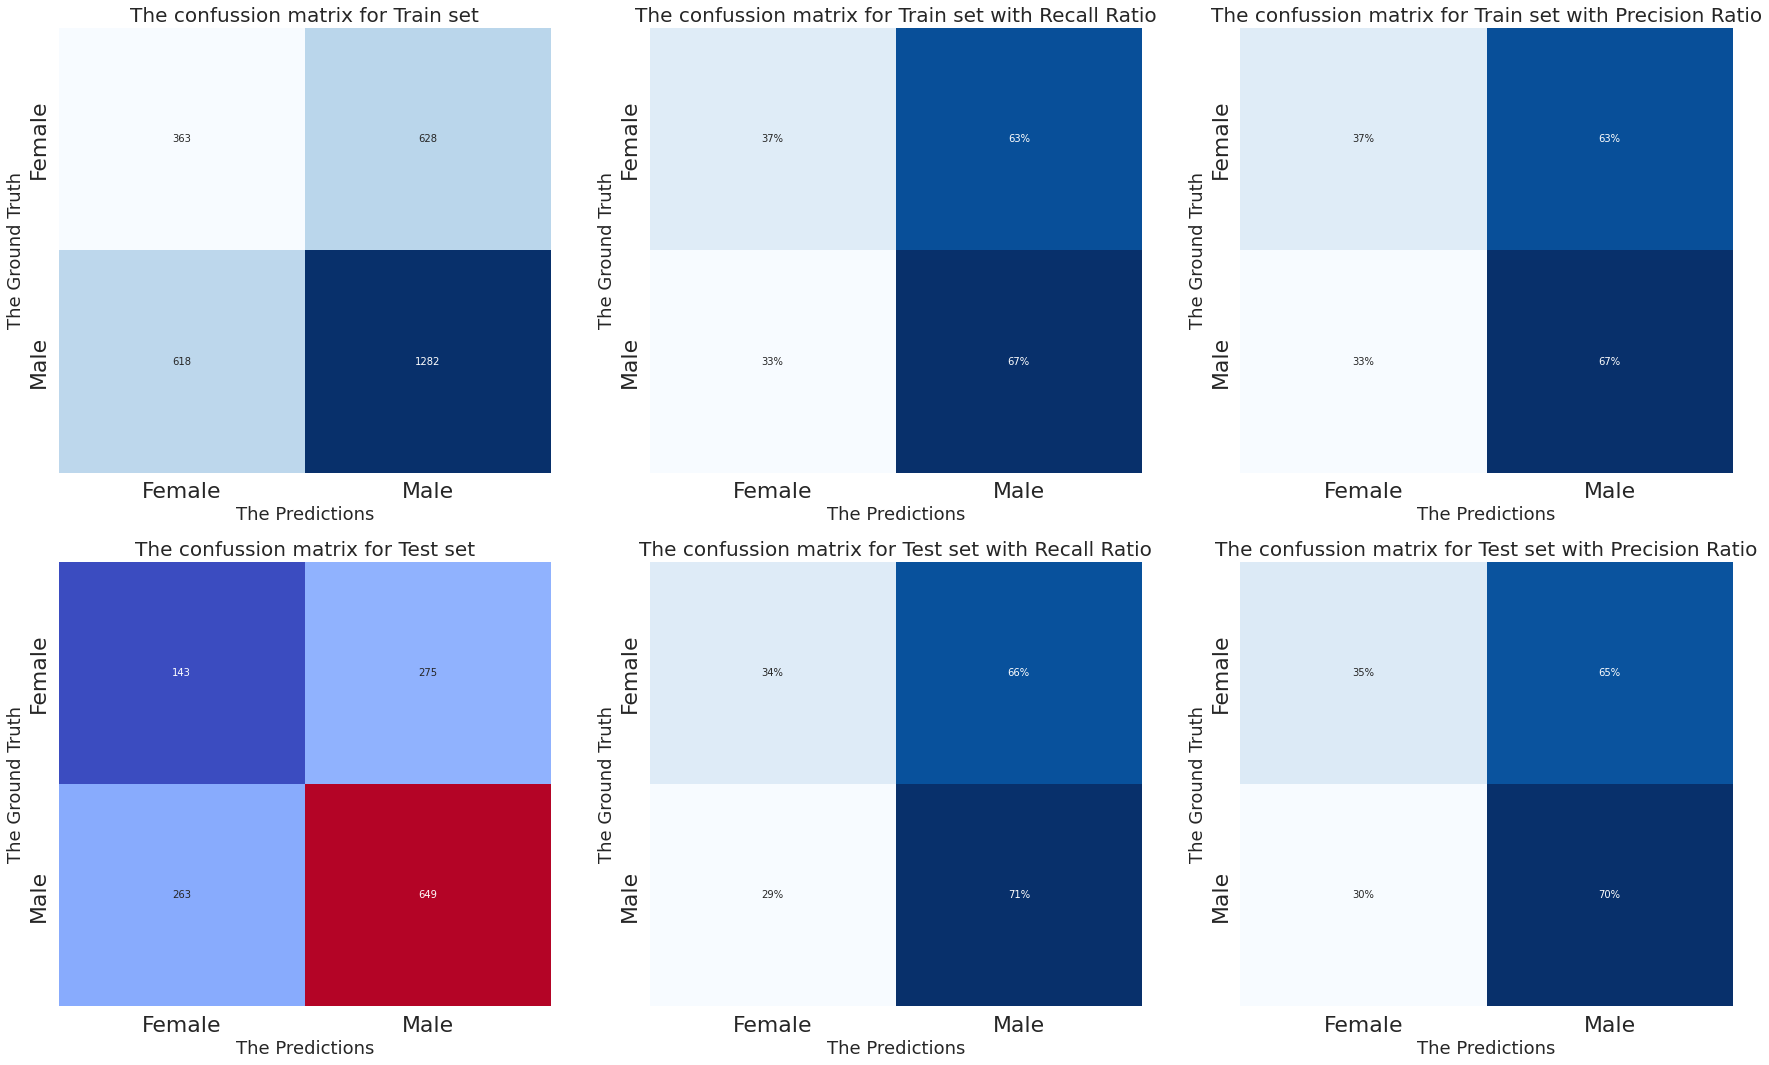

In [19]:

cm_train = confusion_matrix(y_train , y_pred_train)
cm_test = confusion_matrix(y_test , y_pred_test)


plt.figure(figsize = (30,18))
plt.subplot(2,3,1)
sns.heatmap(data = cm_train , cmap = plt.cm.Blues , cbar = False , yticklabels = ['Female' , 'Male'] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".5g")
plt.title("The confussion matrix for Train set" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)
plt.subplot(2,3,2)
upper_stack = cm_train[0]/np.sum(cm_train , axis = 1)[0]
lower_stack = cm_train[1]/np.sum(cm_train , axis  = 1)[1]
result = np.vstack([upper_stack , lower_stack])
sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , yticklabels = ["Female" , "Male"] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".0%")
plt.title("The confussion matrix for Train set with Recall Ratio" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)
plt.subplot(2,3,3)
left_stack = cm_train[:,0]/np.sum(cm_train , axis = 0)[0]
right_stack = cm_train[:,1]/np.sum(cm_train , axis = 0)[1]
final = np.stack([left_stack , right_stack])
sns.heatmap(data = final , cmap = plt.cm.Blues , cbar = False , yticklabels = ["Female" , "Male"] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".0%")
plt.title("The confussion matrix for Train set with Precision Ratio" , fontsize = 20)
plt.xlabel("The Predictions" , fontsize = 18)
plt.ylabel("The Ground Truth" , fontsize = 18)


plt.subplot(2,3,4)
sns.heatmap(data = cm_test , cmap = plt.cm.coolwarm , cbar = False , yticklabels = ['Female' , 'Male'] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".5g")
plt.title("The confussion matrix for Test set" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)
plt.subplot(2,3,5)
upper_stack = cm_test[0]/np.sum(cm_test , axis = 1)[0]
lower_stack = cm_test[1]/np.sum(cm_test , axis  = 1)[1]
result = np.vstack([upper_stack , lower_stack])
sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , yticklabels = ["Female" , "Male"] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".0%")
plt.title("The confussion matrix for Test set with Recall Ratio" , fontsize = 20)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.xlabel("The Predictions" , fontsize = 18)
plt.subplot(2,3,6)
left_stack = cm_test[:,0]/np.sum(cm_test , axis = 0)[0]
right_stack = cm_test[:,1]/np.sum(cm_test , axis = 0)[1]
final = np.stack([left_stack , right_stack])
sns.heatmap(data = final , cmap = plt.cm.Blues , cbar = False , yticklabels = ["Female" , "Male"] , xticklabels = ["Female" , "Male"] , annot = True , fmt = ".0%")
plt.title("The confussion matrix for Test set with Precision Ratio" , fontsize = 20)
plt.xlabel("The Predictions" , fontsize = 18)
plt.ylabel("The Ground Truth" , fontsize = 18)
plt.show()

# Roc Curve for Functional API

84/84 [==============================] - 303s 4s/step


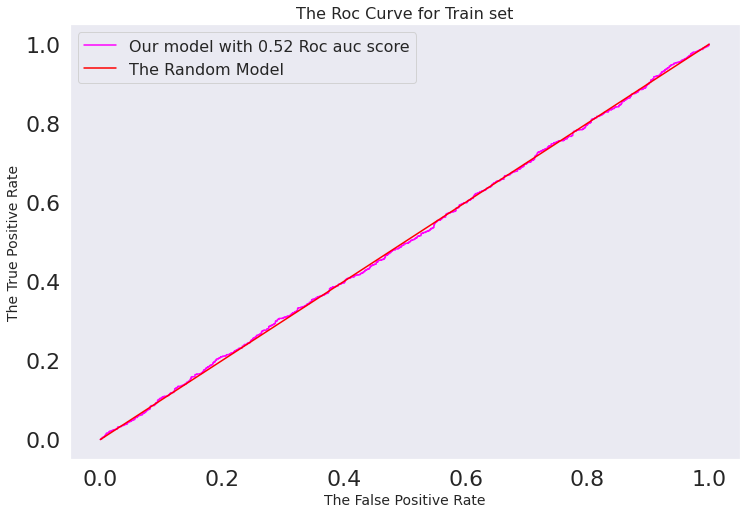

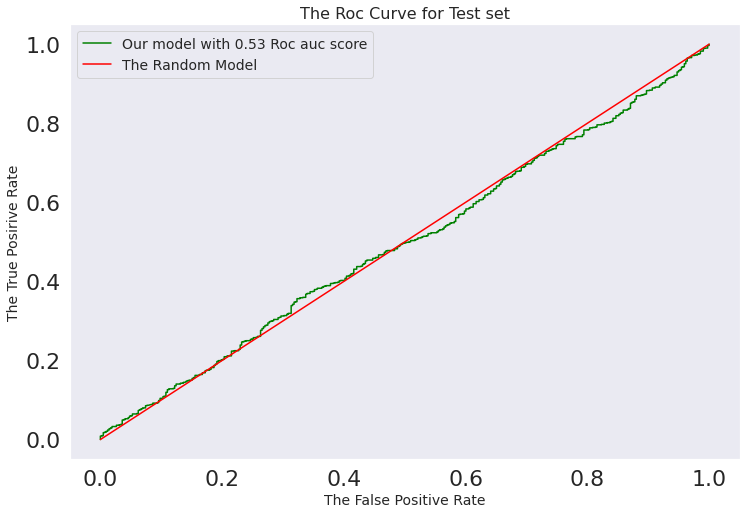

In [20]:
y_pred_proba_train = tf.squeeze(model_2.predict(train_set))
y_pred_proba_test = tf.squeeze(model_2.predict(test_set))

plt.figure(figsize = (12,8))


fpr,tpr , _ = roc_curve(y_train , y_pred_proba_train)
plt.plot(fpr, tpr , label = f"Our model with {np.round(roc_train , 2)} Roc auc score" , c = "magenta")
plt.plot([0,1] , [0,1] , label = "The Random Model" , c = "red")
plt.title("The Roc Curve for Train set" , fontsize = 16)
plt.xlabel("The False Positive Rate" , fontsize = 14)
plt.ylabel("The True Positive Rate" , fontsize = 14)
plt.grid()
plt.legend(loc = "best" , fontsize = 16)
plt.show()

print()
plt.figure(figsize = (12,8))
fpr,tpr , _ = roc_curve(y_test , y_pred_proba_test)
plt.plot(fpr, tpr, label = f"Our model with {np.round(roc_test,2)} Roc auc score" , c = "green")
plt.plot([0,1] , [0,1] , label = "The Random Model" , c = "red")
plt.title("The Roc Curve for Test set" , fontsize = 16)
plt.ylabel("The True Posirive Rate" , fontsize = 14)
plt.xlabel("The False Positive Rate" , fontsize = 14)
plt.grid()
plt.legend(loc = "best" , fontsize = 14)
plt.show()

# Predictions of women

1/1 [==============================] - 0s 290ms/step


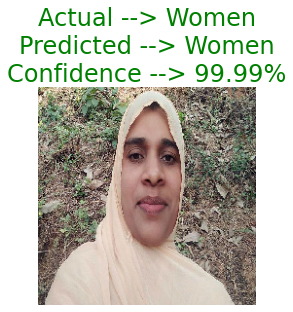


1/1 [==============================] - 0s 287ms/step


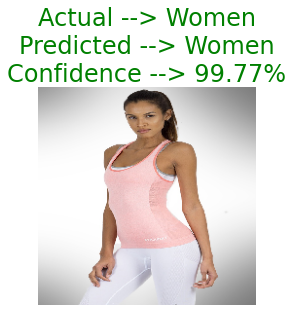


1/1 [==============================] - 0s 273ms/step


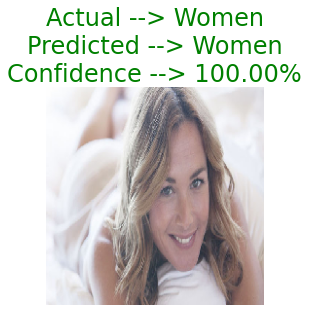


1/1 [==============================] - 0s 344ms/step


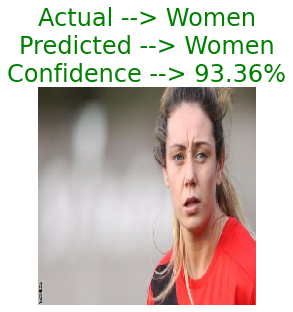


1/1 [==============================] - 0s 278ms/step


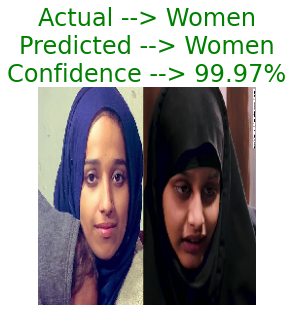

In [24]:
CUSTOM_OBJECTS = {'KerasLayer':hub.KerasLayer}
make_random_predictions(class_name="women" , model_path="/work/Feature_Extraction_Resnet_50.h5" , vgg_model=False , custom_objects = CUSTOM_OBJECTS)

# Predictions of men

1/1 [==============================] - 0s 280ms/step


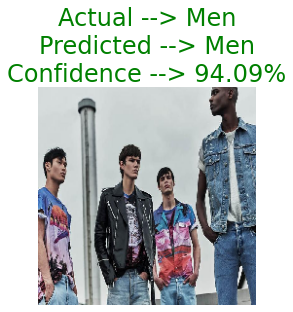


1/1 [==============================] - 0s 285ms/step


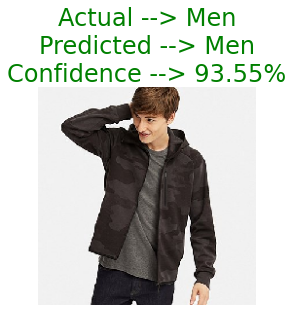


1/1 [==============================] - 0s 272ms/step


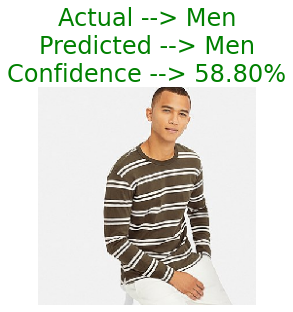


1/1 [==============================] - 0s 265ms/step


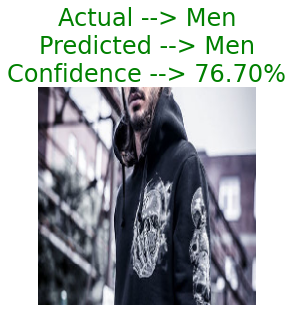


1/1 [==============================] - 0s 268ms/step


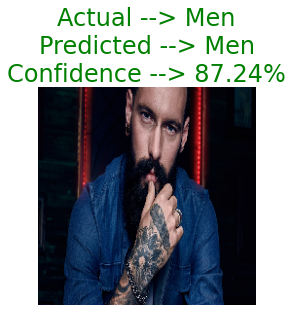

In [25]:
make_random_predictions(class_name="men" , model_path="/work/Feature_Extraction_Resnet_50.h5" , vgg_model=False , custom_objects = CUSTOM_OBJECTS)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aecf7276-0135-45de-9959-147dce059a01' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>